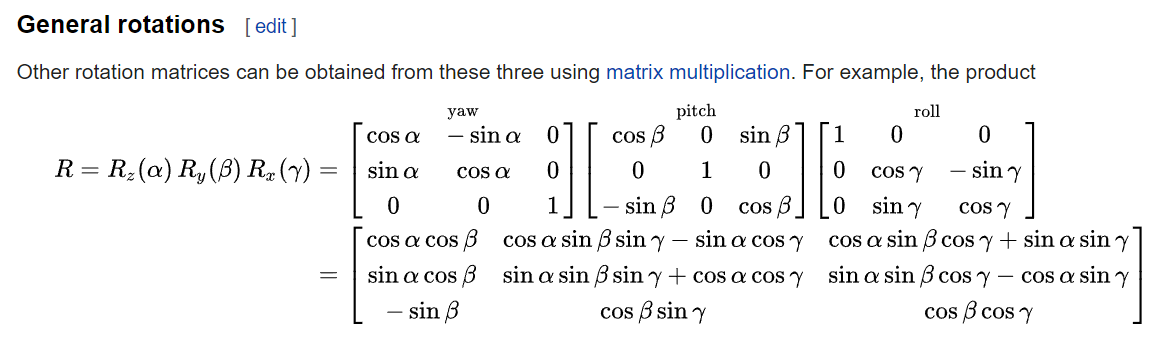

Yaw fra landingsbane:

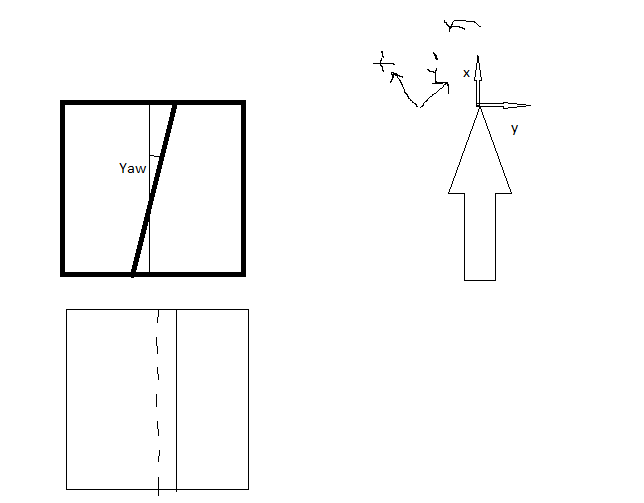

In [78]:
import numpy as np

#Rotationsmatrix
def rotate(a,b,c,x):
    R = np.array([[np.cos(a)*np.cos(b),np.cos(a)*np.sin(b)*np.sin(c)-np.sin(a)*np.cos(c),np.cos(a)*np.sin(b)*np.cos(c)+np.sin(a)*np.sin(c)],
    [np.sin(a)*np.cos(b),np.sin(a)*np.sin(b)*np.sin(c)+np.cos(a)*np.cos(c),np.sin(a)*np.sin(b)*np.cos(c)-np.cos(a)*np.sin(c)],
    [-np.sin(b),np.cos(b)*np.sin(c),np.cos(b)*np.cos(c)]])

    M = R@x
    return(M)

a = np.pi/2 #yaw
b=np.pi/2 # pitch
c=np.pi/2 # roll

x = np.array([2,2,1])
Yaw = np.array([[np.cos(a),-np.sin(a),0],[np.sin(a),np.cos(a),0],[0,0,1]]) #rotation om z
Pitch = np.array([[np.cos(b),0,np.sin(b)],[0,1,0],[-np.sin(b),0,np.cos(b)]]) #roation om y
Roll = np.array([[1,0,0],[0,np.cos(c),-np.sin(c)],[0,np.sin(c),np.cos(c)]]) #rotation om x

#print(Yaw@Pitch@Roll@x)

print(x,"rotated by yaw: {}, pitch: {}, roll: {}\n".format(a,b,c),rotate(a,0,0,x))

[2 2 1] rotated by yaw: 1.5707963267948966, pitch: 1.5707963267948966, roll: 1.5707963267948966
 [-2.  2.  1.]


In [8]:
import numpy as np

#Importér datafiler
magdata = np.genfromtxt("mag_fil.csv",delimiter=",",names=True,dtype=None,encoding=None)
imutidsdata = open("IMUtid.txt","r").read().splitlines()
imudata = np.genfromtxt("state.csv",delimiter=",",names=True,dtype=None,encoding=None)
yawdata = np.genfromtxt("Yaw.csv",delimiter=";",names=True,dtype=None,encoding=None)
imuSensor = np.genfromtxt("RawSensors.csv",delimiter=",",names=True,dtype=None,encoding=None) #meget upræcis!!

#konvertér timestamp til sekunder
def convert_time(time_stamp):
    time = time_stamp.split(" ")[1].split(":")
    seconds = int(time[0])*60*60+int(time[1])*60+float(time[2])
    return(seconds)

starttid = convert_time(imutidsdata[0]) #startid for IMU data

#timestamps for hhv magnetometer, kamera, IMU
mag_time = [convert_time(magdata[i][0]) for i in range(len(magdata))]
billede_time = [convert_time(yawdata[i][0]) for i in range(len(yawdata))]
imu_tid = [starttid + i*0.10 for i in range(len(imudata))]

#sammenlign billedetid med sensortid
def sammenlign_tid(billede_tid,sensor_tid):
    sensor_index = []
    j = 0
    for i in billede_tid:
        while sensor_tid[j] < i:
            j += 1
        if sensor_tid[j] >= i:
            sensor_index.append(j)
            pass
    return sensor_index

#returnerer liste med index i sensorlisten for tilsvarende billede tid 
mag_index = sammenlign_tid(billede_time,mag_time)
imu_index = sammenlign_tid(billede_time,imu_tid)

#al data, der er synkroniseret i tid
magnetometer_vector = [[magdata[i][7],magdata[i][8],magdata[i][9]] for i in mag_index] #Fluxgate 3D magnetometer data
imuMag = [[imuSensor[i][9]/10,imuSensor[i][10]/10,imuSensor[i][11]/10] for i in imu_index] #IMU magnetometer data
roll =  [imudata[i][43]*np.pi/180 for i in imu_index] #roll fra IMU
pitch = [imudata[i][44]*np.pi/180 for i in imu_index] #pitch fra IMU
yaw = [-float(yawdata[i][3].replace(",","."))*np.pi/180 for i in range(len(yawdata))] #pitch fra billede

#----------------------------#
#Rotationsmatrix
def rotate(a,b,c,x):
    R = np.array([[np.cos(a)*np.cos(b),np.cos(a)*np.sin(b)*np.sin(c)-np.sin(a)*np.cos(c),np.cos(a)*np.sin(b)*np.cos(c)+np.sin(a)*np.sin(c)],
    [np.sin(a)*np.cos(b),np.sin(a)*np.sin(b)*np.sin(c)+np.cos(a)*np.cos(c),np.sin(a)*np.sin(b)*np.cos(c)-np.cos(a)*np.sin(c)],
    [-np.sin(b),np.cos(b)*np.sin(c),np.cos(b)*np.cos(c)]])

    M = R@x
    return(M)

#Beregning af vinkel mellem vektor og x-aksen (parraleol med landingsbane)
def vinkel(vektor):
    return np.arccos(np.abs(vektor[0])/np.linalg.norm(vektor))*180/np.pi

#Beregning af kurs for hver måling!
vinkler = []
for i in range(len(mag_index)):
    # print("pitch",pitch[i],"roll",roll[i],"yaw",yaw[i])
    rotated_vector = rotate(yaw[i],pitch[i],roll[i],np.array(magnetometer_vector[i]))
    print(i,": bird_vector",magnetometer_vector[i],"corrected_vector",rotated_vector) 

    kurs = 360-vinkel(rotated_vector)
    vinkler.append(kurs)

    print("kurs: ",kurs)

print("gennemsnit: ", np.mean(vinkler))

0 : bird_vector [2.5816630798974516, -21.669398480056145, -32.089094648701426] IMU mag [4.1900635, -27.55432, 17.605591] corrected_vector [ -0.30690911 -17.33154501 -34.71975179]
kurs:  270.4531410609785
1 : bird_vector [1.5056532426831737, -19.878298820032338, -33.792349377910696] IMU mag [2.9968262, -29.467773, 19.589233] corrected_vector [ -2.40248775 -17.12043261 -35.2201004 ]
kurs:  273.5106601843362
2 : bird_vector [1.8643231884212863, -17.908089194006152, -38.63317860829493] IMU mag [3.721401, -34.504047, 25.873676] corrected_vector [  0.49676029 -18.49071605 -38.39979815]
kurs:  270.66778703364525
3 : bird_vector [5.989027564409302, -12.713900179937113, -49.749156841029084] IMU mag [7.32945, -39.5595, 33.365305] corrected_vector [  6.55470044 -15.79043346 -48.78717484]
kurs:  277.28430266168726
4 : bird_vector [2.850665539201036, -12.624345196935934, -54.76927604290902] IMU mag [2.495466, -39.052036, 32.833425999999996] corrected_vector [  1.39782387 -13.44078033 -54.63117696]
